In [1]:
# import libraraies

import json
import requests

## Step 1: Data acquisition

This step will call the legacy and page view endpoint with access site of desktop-site, mobile-site and desktop, mobile-app, mobile-web respective, 

The Legacy Pagecounts API provides access to desktop and mobile traffic data from December 2007 through July 2016.
The Pageviews API provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month.

The data will be saved in 5 separate file in json format with naming coversion of apiname_accesstype_firstmonth-lastmonth.json 


In [2]:
# End point APIs
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [3]:
# Parameters to query end point API
# see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end

# parametesr for legacy pagecounts API
pagecounts_desktop_site_params = {
    "project" : "en.wikipedia.org",
     "access-site" : "desktop-site",
     "granularity" : "monthly",
     "start" : "2007120100",
     # for end use 1st day of month following final month of data
     "end" : "2016080100"
}

pagecounts_mobile_site_params = {
    "project" : "en.wikipedia.org",
     "access-site" : "mobile-site",
     "granularity" : "monthly",
     "start" : "2007120100",
     # for end use 1st day of month following final month of data
     "end" : "2016080100"
}

# parameters for Pageviews API
pageviews_desktop_params = {
    "project" : "en.wikipedia.org",
    "access" : "desktop",
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2015070100",
    # for end use 1st day of month following final month of data
    "end" : '2021090100'
                        
}

pageviews_mobile_app_params = {
    "project" : "en.wikipedia.org",
    "access" : "mobile-app",
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2015070100",
    # for end use 1st day of month following final month of data
    "end" : '2021090100'
                        
}

pageviews_mobile_web_params = {
    "project" : "en.wikipedia.org",
    "access" : "mobile-web",
    "agent" : "user",
    "granularity" : "monthly",
    "start" : "2015070100",
    # for end use 1st day of month following final month of data
    "end" : '2021090100'     
}

In [4]:
headers = {
    'User-Agent': 'https://github.com/IvyLinMS',
    'From': 'ivylin@uw.edu'
}

In [5]:
# Method to call API and dump result into json file
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    return response

def dump_api_result_to_json(filename, endpoint, parameters):
    data = api_call(endpoint, parameters)
    with open(filename, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False)

In [6]:
# 5 file names
pagecounts_desktop_file = 'pagecounts_desktop-site_200712-202108.json'
pagecounts_mobile_file = 'pagecounts_mobile-site_200712-202108.json'
pageview_desktop_file = 'pageviews_desktop_200712-202108.json'
pageview_mobile_app_file = 'pageviews_mobile-app_200712-202108.json'
pageview_mobile_web_file = 'pageviews_mobile-web_200712-202108.json'

In [7]:
# Use the 5 parametes defined above to save the result
dump_api_result_to_json(pagecounts_desktop_file, endpoint_legacy, pagecounts_desktop_site_params)
dump_api_result_to_json(pagecounts_mobile_file, endpoint_legacy, pagecounts_mobile_site_params)
dump_api_result_to_json(pageview_desktop_file, endpoint_pageviews, pageviews_desktop_params)
dump_api_result_to_json(pageview_mobile_app_file, endpoint_pageviews, pageviews_mobile_app_params)
dump_api_result_to_json(pageview_mobile_web_file, endpoint_pageviews, pageviews_mobile_web_params)

## Step 2: Data processing

In this step, clean up the data downloaded from step 1

+ Load data from json file into a data frame and do extra process for combination
   + For legacy page count API data, keep 'access-site', 'timestamp', 'count' column, rename access-site and count column name to make it consistent with page view API data, also update the access type with expected name
   + For page view API data, keep 'access', 'timestamp', 'views' column, update the access type with expected name
   
+ Sum the two mobile app and mobile web data from page view API into a single acess type pageview_mobile_views
+ Combine all data frame into a single data frame
+ Pivot the combined data to make different access type has separate column
+ Replace not available data with 0
+ Extra year and month column from timestamp column
+ Create pagecount_all_views and pageview_all_views by sum the desktop view and mobile view from pagecount and pageview API respectively
+ Reorder the data frame and save to final CSV output


In [8]:
# method to load the json file into a data frame
import pandas as pd

def load_json_to_df(file):
    with open(file) as f:
        data = json.load(f)
    return pd.DataFrame.from_dict(data['items'])

In [9]:
# clean up leagcy page count API data

def clean_up_pagecount_api_data(datafile, access_type, view_name):
    data = load_json_to_df(datafile)
    data_cleaned = data[['access-site', 'timestamp', 'count']].copy()
    # rename the column to make it consistent with page view API
    data_cleaned.rename(columns = {'access-site': 'access'}, inplace=True)
    data_cleaned.rename(columns = {'count': 'views'}, inplace=True)
    
    data_cleaned['access'].replace({access_type: view_name}, inplace=True)
    return data_cleaned
    



In [10]:
pagecounts_desktop_data = clean_up_pagecount_api_data(pagecounts_desktop_file, 'desktop-site', 'pagecount_desktop_views')
pagecounts_desktop_data


,access,timestamp,views
0,pagecount_desktop_views,2007120100,2998331524
1,pagecount_desktop_views,2008010100,4930902570
2,pagecount_desktop_views,2008020100,4818393763
3,pagecount_desktop_views,2008030100,4955405809
4,pagecount_desktop_views,2008040100,5159162183
...,...,...,...
99,pagecount_desktop_views,2016030100,5407676056
100,pagecount_desktop_views,2016040100,5572235399
101,pagecount_desktop_views,2016050100,5330532334
102,pagecount_desktop_views,2016060100,4975092447


In [11]:
pagecounts_mobile_data = clean_up_pagecount_api_data(pagecounts_mobile_file, 'mobile-site', 'pagecount_mobile_views')
pagecounts_mobile_data


,access,timestamp,views
0,pagecount_mobile_views,2014100100,3091546685
1,pagecount_mobile_views,2014110100,3027489668
2,pagecount_mobile_views,2014120100,3278950021
3,pagecount_mobile_views,2015010100,3485302091
4,pagecount_mobile_views,2015020100,3091534479
5,pagecount_mobile_views,2015030100,3330832588
6,pagecount_mobile_views,2015040100,3222089917
7,pagecount_mobile_views,2015050100,3334069483
8,pagecount_mobile_views,2015060100,3038162463
9,pagecount_mobile_views,2015070100,3254472695


In [12]:
# clean up page view API data
def clean_up_pageview_api_data(datafile, access_type, view_name):
    data = load_json_to_df(datafile)
    data_cleaned = data[['access', 'timestamp', 'views']].copy()

    data_cleaned['access'].replace({access_type: view_name}, inplace=True)
    return data_cleaned




In [13]:
pageviews_desktop_data = clean_up_pageview_api_data(pageview_desktop_file, 'desktop', 'pageview_desktop_views')
pageviews_desktop_data

,access,timestamp,views
0,pageview_desktop_views,2015070100,4376666686
1,pageview_desktop_views,2015080100,4332482183
2,pageview_desktop_views,2015090100,4485491704
3,pageview_desktop_views,2015100100,4477532755
4,pageview_desktop_views,2015110100,4287720220
...,...,...,...
69,pageview_desktop_views,2021040100,2882714492
70,pageview_desktop_views,2021050100,2824416177
71,pageview_desktop_views,2021060100,2505971366
72,pageview_desktop_views,2021070100,2765584368


In [14]:
pageview_mobile_app_data = clean_up_pageview_api_data(pageview_mobile_app_file, 'mobile-app', 'pageview_mobile_views')
pageview_mobile_app_data

,access,timestamp,views
0,pageview_mobile_views,2015070100,109624146
1,pageview_mobile_views,2015080100,109669149
2,pageview_mobile_views,2015090100,96221684
3,pageview_mobile_views,2015100100,94523777
4,pageview_mobile_views,2015110100,94353925
...,...,...,...
69,pageview_mobile_views,2021040100,162260497
70,pageview_mobile_views,2021050100,166485079
71,pageview_mobile_views,2021060100,150704624
72,pageview_mobile_views,2021070100,161461155


In [15]:
pageview_mobile_web_data = clean_up_pageview_api_data(pageview_mobile_web_file, 'mobile-web', 'pageview_mobile_views')
pageview_mobile_web_data

,access,timestamp,views
0,pageview_mobile_views,2015070100,3179131148
1,pageview_mobile_views,2015080100,3192663889
2,pageview_mobile_views,2015090100,3073981649
3,pageview_mobile_views,2015100100,3173975355
4,pageview_mobile_views,2015110100,3142247145
...,...,...,...
69,pageview_mobile_views,2021040100,4596834586
70,pageview_mobile_views,2021050100,4810094479
71,pageview_mobile_views,2021060100,4433805793
72,pageview_mobile_views,2021070100,4617448266


In [16]:
# merge the pageview_mobile_app_data and pageview_mobile_web_data
pageview_mobile_count = pageview_mobile_app_data['views'] + pageview_mobile_web_data['views']
pageview_mobile_data = pd.concat([pageview_mobile_app_data['access'], pageview_mobile_app_data['timestamp'], pageview_mobile_count], axis=1)
pageview_mobile_data

,access,timestamp,views
0,pageview_mobile_views,2015070100,3288755294
1,pageview_mobile_views,2015080100,3302333038
2,pageview_mobile_views,2015090100,3170203333
3,pageview_mobile_views,2015100100,3268499132
4,pageview_mobile_views,2015110100,3236601070
...,...,...,...
69,pageview_mobile_views,2021040100,4759095083
70,pageview_mobile_views,2021050100,4976579558
71,pageview_mobile_views,2021060100,4584510417
72,pageview_mobile_views,2021070100,4778909421


In [17]:
# combine all 4 data frame into a single df
combined_data = pd.concat( [pagecounts_desktop_data, pagecounts_mobile_data, pageviews_desktop_data, pageview_mobile_data])
combined_data

,access,timestamp,views
0,pagecount_desktop_views,2007120100,2998331524
1,pagecount_desktop_views,2008010100,4930902570
2,pagecount_desktop_views,2008020100,4818393763
3,pagecount_desktop_views,2008030100,4955405809
4,pagecount_desktop_views,2008040100,5159162183
...,...,...,...
69,pageview_mobile_views,2021040100,4759095083
70,pageview_mobile_views,2021050100,4976579558
71,pageview_mobile_views,2021060100,4584510417
72,pageview_mobile_views,2021070100,4778909421


In [18]:

pivot_data = combined_data.pivot(index='timestamp', columns='access', values='views')
pivot_data

access,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobile_views
timestamp,,,,
2007120100,2.998332e+09,NaN,NaN,NaN
2008010100,4.930903e+09,NaN,NaN,NaN
2008020100,4.818394e+09,NaN,NaN,NaN
2008030100,4.955406e+09,NaN,NaN,NaN
2008040100,5.159162e+09,NaN,NaN,NaN
...,...,...,...,...
2021040100,NaN,NaN,2.882714e+09,4.759095e+09
2021050100,NaN,NaN,2.824416e+09,4.976580e+09
2021060100,NaN,NaN,2.505971e+09,4.584510e+09


In [19]:
pivot_data = pivot_data.reset_index()
pivot_data.fillna(0, inplace=True)
pivot_data

access,timestamp,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobile_views
0,2007120100,2.998332e+09,0.0,0.000000e+00,0.000000e+00
1,2008010100,4.930903e+09,0.0,0.000000e+00,0.000000e+00
2,2008020100,4.818394e+09,0.0,0.000000e+00,0.000000e+00
3,2008030100,4.955406e+09,0.0,0.000000e+00,0.000000e+00
4,2008040100,5.159162e+09,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...
160,2021040100,0.000000e+00,0.0,2.882714e+09,4.759095e+09
161,2021050100,0.000000e+00,0.0,2.824416e+09,4.976580e+09
162,2021060100,0.000000e+00,0.0,2.505971e+09,4.584510e+09
163,2021070100,0.000000e+00,0.0,2.765584e+09,4.778909e+09


In [20]:
pivot_data['year'] = pivot_data.apply(lambda r: r.timestamp[0:4], axis=1)
pivot_data['month'] = pivot_data.apply(lambda r: r.timestamp[4:6], axis=1)



In [21]:
pivot_data['pagecount_all_views'] = pivot_data['pagecount_desktop_views'] + pivot_data['pagecount_mobile_views']
pivot_data['pageview_all_views'] = pivot_data['pageview_desktop_views'] + pivot_data['pageview_mobile_views']
pivot_data

access,timestamp,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobile_views,year,month,pagecount_all_views,pageview_all_views
0,2007120100,2.998332e+09,0.0,0.000000e+00,0.000000e+00,2007,12,2.998332e+09,0.000000e+00
1,2008010100,4.930903e+09,0.0,0.000000e+00,0.000000e+00,2008,01,4.930903e+09,0.000000e+00
2,2008020100,4.818394e+09,0.0,0.000000e+00,0.000000e+00,2008,02,4.818394e+09,0.000000e+00
3,2008030100,4.955406e+09,0.0,0.000000e+00,0.000000e+00,2008,03,4.955406e+09,0.000000e+00
4,2008040100,5.159162e+09,0.0,0.000000e+00,0.000000e+00,2008,04,5.159162e+09,0.000000e+00
...,...,...,...,...,...,...,...,...,...
160,2021040100,0.000000e+00,0.0,2.882714e+09,4.759095e+09,2021,04,0.000000e+00,7.641810e+09
161,2021050100,0.000000e+00,0.0,2.824416e+09,4.976580e+09,2021,05,0.000000e+00,7.800996e+09
162,2021060100,0.000000e+00,0.0,2.505971e+09,4.584510e+09,2021,06,0.000000e+00,7.090482e+09
163,2021070100,0.000000e+00,0.0,2.765584e+09,4.778909e+09,2021,07,0.000000e+00,7.544494e+09


In [22]:
# output the final data 
final_data = pivot_data[['year','month','pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views','pageview_mobile_views']].copy()
final_data['pagecount_desktop_views'] = final_data['pagecount_desktop_views'].astype('int64')
final_data['pagecount_mobile_views'] = final_data['pagecount_mobile_views'].astype('int64')
final_data['pageview_desktop_views'] = final_data['pageview_desktop_views'].astype('int64')
final_data['pageview_mobile_views'] = final_data['pageview_mobile_views'].astype('int64')
final_data['pagecount_all_views'] = final_data['pagecount_all_views'].astype('int64')
final_data['pageview_all_views'] = final_data['pageview_all_views'].astype('int64')
final_data

access,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2998331524,2998331524,0,0,0,0
1,2008,01,4930902570,4930902570,0,0,0,0
2,2008,02,4818393763,4818393763,0,0,0,0
3,2008,03,4955405809,4955405809,0,0,0,0
4,2008,04,5159162183,5159162183,0,0,0,0
...,...,...,...,...,...,...,...,...
160,2021,04,0,0,0,7641809575,2882714492,4759095083
161,2021,05,0,0,0,7800995735,2824416177,4976579558
162,2021,06,0,0,0,7090481783,2505971366,4584510417
163,2021,07,0,0,0,7544493789,2765584368,4778909421


In [23]:
final_data.to_csv('en-wikipedia_traffic_200712-202108.csv', index=False)  

## Step 3: Analysis

In this step, plot the data into a line chart with 6 different traffic types.

Based on the final data csv file from previous step, I plotted the graph using Seaborn Lineplot, the 6 lines display the trending by 'PageCount - All traffic', 'PageCount - Desktop traffic', 'PageCount - Mobile traffic', 'PageView - All traffic', 'PageView - Desktop traffic', and 'PageView - Mobile traffic'.

As we can see, the Legacy Pagecounts API provides traffic data from December 2007 through July 2016, then the new Pageviews API provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month.


In [24]:
# prepare data for plot
final_data['year_month']  =  final_data['year'] + '-' + final_data['month']
cleand_data = pd.concat( [final_data['year_month'], 
                         final_data['pagecount_all_views'],
                         final_data['pagecount_desktop_views'],
                         final_data['pagecount_mobile_views'],
                         final_data['pageview_all_views'],
                         final_data['pageview_desktop_views'],
                         final_data['pageview_mobile_views']
                        ], axis=1)
cleand_data

,year_month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007-12,2998331524,2998331524,0,0,0,0
1,2008-01,4930902570,4930902570,0,0,0,0
2,2008-02,4818393763,4818393763,0,0,0,0
3,2008-03,4955405809,4955405809,0,0,0,0
4,2008-04,5159162183,5159162183,0,0,0,0
...,...,...,...,...,...,...,...
160,2021-04,0,0,0,7641809575,2882714492,4759095083
161,2021-05,0,0,0,7800995735,2824416177,4976579558
162,2021-06,0,0,0,7090481783,2505971366,4584510417
163,2021-07,0,0,0,7544493789,2765584368,4778909421


In [25]:
to_plot = cleand_data.melt(id_vars=['year_month'], 
        var_name="traffic_type", 
        value_name="views")
to_plot

,year_month,traffic_type,views
0,2007-12,pagecount_all_views,2998331524
1,2008-01,pagecount_all_views,4930902570
2,2008-02,pagecount_all_views,4818393763
3,2008-03,pagecount_all_views,4955405809
4,2008-04,pagecount_all_views,5159162183
...,...,...,...
985,2021-04,pageview_mobile_views,4759095083
986,2021-05,pageview_mobile_views,4976579558
987,2021-06,pageview_mobile_views,4584510417
988,2021-07,pageview_mobile_views,4778909421


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


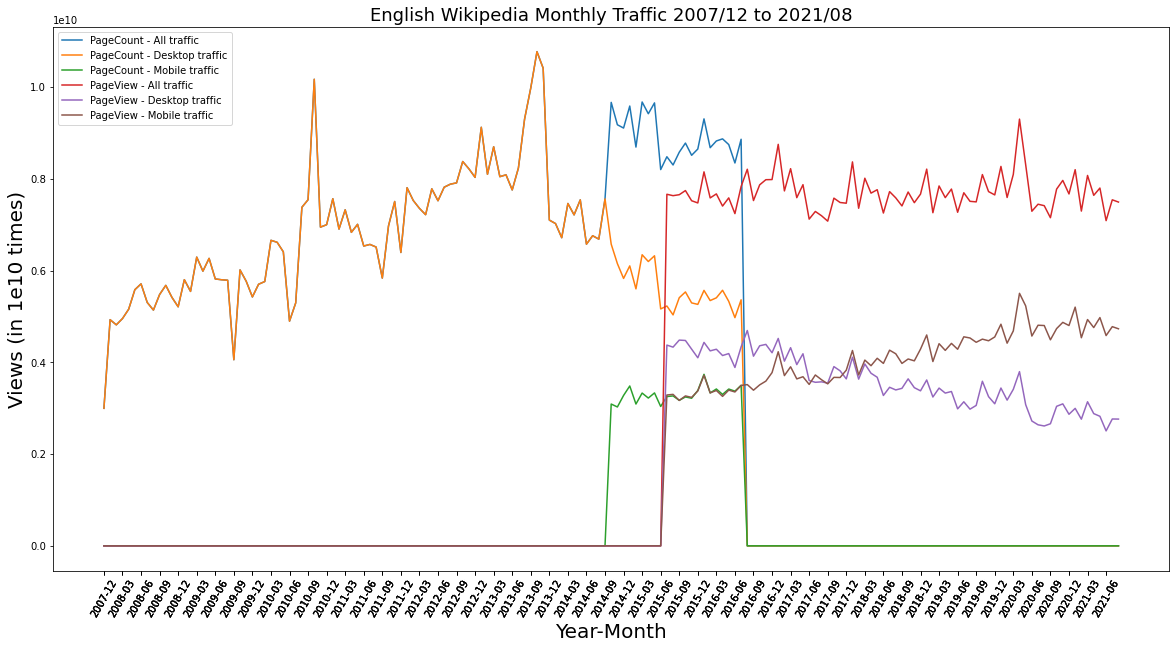

In [38]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=60)
graph = sns.lineplot(
             x="year_month", 
             y="views",
             estimator=sum,
             ci=None,
             hue="traffic_type", 
             data=to_plot)

graph.set(xticks=to_plot.year_month[0::6])
graph.set_title('English Wikipedia Monthly Traffic 2007/12 to 2021/08', size = 18)
graph.set_xlabel('Year-Month', size = 20)
graph.set_ylabel('Views (in 1e10 times)', size = 20)
graph.legend(labels = ['PageCount - All traffic', 'PageCount - Desktop traffic', 'PageCount - Mobile traffic', 'PageView - All traffic', 'PageView - Desktop traffic', 'PageView - Mobile traffic'])

# save the plot to png
plt.savefig('wikipedia_traffic.png')
